# Step 5 | Image Classification with CNN all 101 food classes (high-resolution images)

In the section below, we will rebuild the algorithm as presented in notebook *04_ig_image_classificationfull_dataset*, with the only difference that we will use images of **<mark>512 x 512 resolution<mark/>**, in the hope that we will increase the classifier's accuracy. <br/>

We will then follow the steps below:
1. Set up the data, learner and image augmentation transform functions
2. Load final version of the model - *food_mix_full_ds_2* - as tested in notebook 04 (based on 256 x 256 image resolution)
3. Create new dataloader  *data_hr* containing all 512 x 512 resolution food images
4. Find optimal learning rate and train the model
5. Create dataloader for test data and build predictions with Test Time Augmentation (TTA) only as this approach proved to deliver a greater top-1 accuracy on lower resolution images
6. Visualize results with TSNE

For more exhaustive explanations about the code and its theoretical underpinnings please refer to *04_ig_image_classificationfull_dataset*.

## Initial Setup

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True) # force remount to ensure new directories are included

Mounted at /content/gdrive


In [2]:
# check GPU is enabled
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# initial imports
import seaborn as sns
import fastai.vision as fv
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from sklearn.manifold import TSNE
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL


# ignore warning
import warnings
warnings.filterwarnings('ignore')

## Create dataloader

We will start by defining the image augmentation transform functions and transform our data accordingly. While creating the dataloader, we specify that 10% of the image data should be kept aside as a validation set for model scoring.

In [4]:
# define paths
path_meta = "/content/gdrive/MyDrive/Colab/data/meta/"
path_test = "/content/gdrive/MyDrive/Colab/data/test"
path_train = "/content/gdrive/MyDrive/Colab/data/train"

In [5]:
# batch size
bs = 25

In [6]:
# image augmentation transform functions
tfms = get_transforms(do_flip=True, 
                      flip_vert=True, 
                      max_rotate=10.0,
                      max_zoom = 1.1,
                      max_lighting=0.25,
                      max_warp=0.25)

In [7]:
# create dataloader
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.1, seed=42) # validation set = 10%
                                       .label_from_folder(classes=None) 
                                       .transform(tfms=tfms, size=256)
                                       .databunch(bs=bs, num_workers=6))

In [8]:
data

ImageDataBunch;

Train: LabelList (68171 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
cheese_plate,cheese_plate,cheese_plate,cheese_plate,cheese_plate
Path: /content/gdrive/MyDrive/Colab/data/train;

Valid: LabelList (7574 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
cheese_plate,gyoza,creme_brulee,shrimp_and_grits,huevos_rancheros
Path: /content/gdrive/MyDrive/Colab/data/train;

Test: None

## CNN Model Training

In a relatively straightforward way, we create a convnet style learner from the dataloader object and model inferred from it wuth a backbone specified by the pre-trained model architecture (ResNet50 in our case).

In [9]:
# create learner object from fast.ai library
# learner is a container of the data, the model, the optimizer and other parameters for training
learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=error_rate,
                    ps=0.4, 
                    wd=5e-3)

# implement mixup augmentation
learn = learn.mixup()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


In [10]:
# check weight decay
learn.wd

0.005

In [11]:
# check model linear head
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.4, inplace=False)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [12]:
# visualize model
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [13]:
# check loss function
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
# load model
learn.load('/content/gdrive/MyDrive/Colab/data/train/models/food_mix_full_ds_2'); 

In [15]:
# interpret classification output
model_interp = ClassificationInterpretation.from_learner(learn.to_fp32())
losses,idxs = model_interp.top_losses()

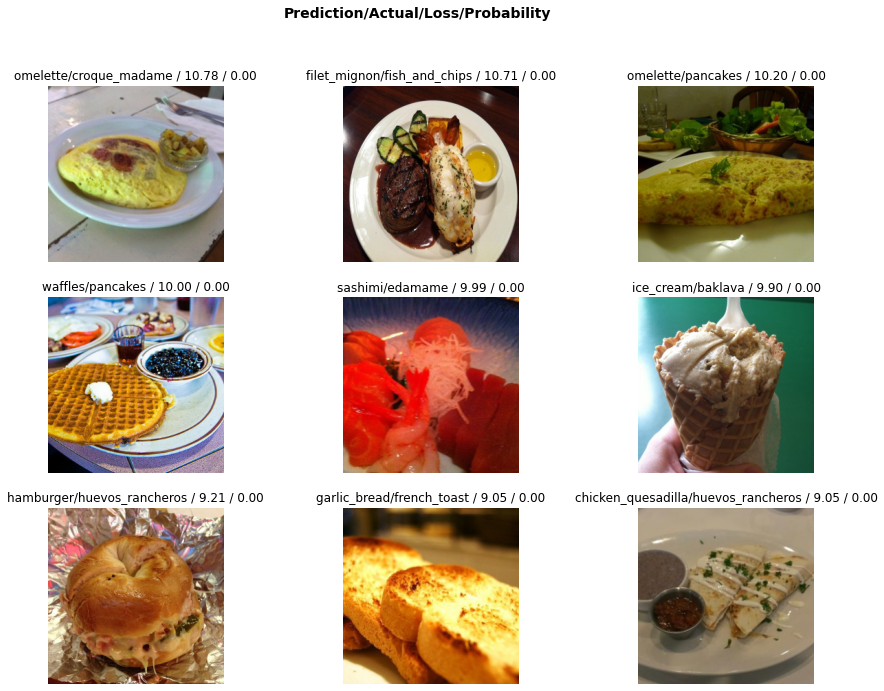

In [16]:
# identify most misclassified classes
model_interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [18]:
# identified most misclassified classes
model_interp.most_confused(min_val=4)

[('steak', 'filet_mignon', 11),
 ('chocolate_mousse', 'chocolate_cake', 10),
 ('cheesecake', 'strawberry_shortcake', 9),
 ('dumplings', 'gyoza', 9),
 ('onion_rings', 'fried_calamari', 8),
 ('prime_rib', 'filet_mignon', 8),
 ('tiramisu', 'chocolate_mousse', 8),
 ('chocolate_cake', 'chocolate_mousse', 7),
 ('filet_mignon', 'steak', 7),
 ('scallops', 'shrimp_and_grits', 7),
 ('apple_pie', 'bread_pudding', 6),
 ('apple_pie', 'cheesecake', 6),
 ('beignets', 'donuts', 6),
 ('bread_pudding', 'apple_pie', 6),
 ('ceviche', 'tuna_tartare', 6),
 ('chocolate_cake', 'tiramisu', 6),
 ('chocolate_mousse', 'panna_cotta', 6),
 ('pork_chop', 'filet_mignon', 6),
 ('pork_chop', 'scallops', 6),
 ('sushi', 'sashimi', 6),
 ('chicken_quesadilla', 'breakfast_burrito', 5),
 ('falafel', 'crab_cakes', 5),
 ('lobster_bisque', 'clam_chowder', 5),
 ('steak', 'pork_chop', 5),
 ('baby_back_ribs', 'steak', 4),
 ('beef_carpaccio', 'tuna_tartare', 4),
 ('cheesecake', 'panna_cotta', 4),
 ('chocolate_mousse', 'ice_cream', 

## Train model on 512 x 512 resolution images

This is the section that differs from notebook #4 in this series. Here, we are creating a new dataloader based on 512 x 512 resolution images, by applying the same image augmentations and other transformations specified before. As before, 10% of the images will be split into a validation set. <br/>

Finally, we are retraining the model based on the high-resolution images.

In [14]:
# pass the same random seed to ensure we're using the same validation set 
# size = 512 to train on high-res images and validation set is 10% of train set
data_hr = (ImageList.from_folder(path_train).split_by_rand_pct(0.10, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=bs, num_workers=6))

In [15]:
data_hr

ImageDataBunch;

Train: LabelList (68171 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
cheese_plate,cheese_plate,cheese_plate,cheese_plate,cheese_plate
Path: /content/gdrive/MyDrive/Colab/data/train;

Valid: LabelList (7574 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
cheese_plate,gyoza,creme_brulee,shrimp_and_grits,huevos_rancheros
Path: /content/gdrive/MyDrive/Colab/data/train;

Test: None

In [16]:
# update learner and freeze model 
learn.data = data_hr
learn = learn.to_fp16(dynamic=True)
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-06
Min loss divided by 10: 1.10E-03


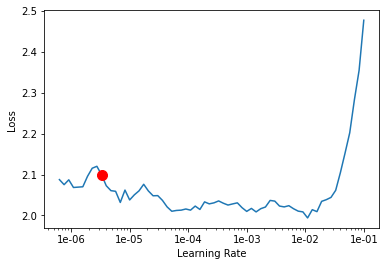

In [22]:
# find optimal learning rate
learn.lr_find()
learn.recorder.plot(skip_end=10, suggestion=True)

In [23]:
# define optimal lr for initial model training
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

3.311311214825911e-06

In [24]:
# train linear head
learn.fit_one_cycle(8, max_lr=slice(min_grad_lr))

epoch,train_loss,valid_loss,error_rate,time
0,2.097998,1.072640,0.268946,51:02
1,2.055649,1.067684,0.266438,25:47
2,2.087207,1.019446,0.256139,26:25
3,2.054870,1.006622,0.258780,26:02
4,2.043570,1.013081,0.253895,26:00
5,2.012214,0.988236,0.248746,26:06
6,2.017139,0.987219,0.248350,26:09
7,2.021687,0.977621,0.248746,26:35


In [25]:
# save model
learn.save('food_mix_full_ds_3')

In [17]:
# load model to continue training when runtime disconnects
#learn.load('food_mix_full_ds_3');

In [18]:
# unfreeze model
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


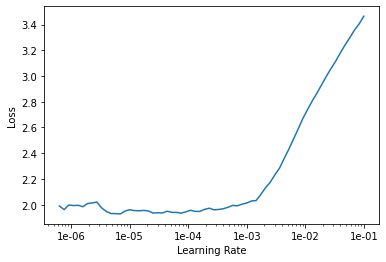

In [19]:
# find optimal learning rate
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [20]:
# train entire model with discriminative learning rates & one cycle policy 
# stop point of the slice corresponds to the lr value right before which the slope of the curve starts increasing again
learn.fit_one_cycle(12, max_lr=slice(3e-5,3e-4)) 

epoch,train_loss,valid_loss,error_rate,time
0,1.734983,0.720724,0.188540,1:42:48
1,1.758416,0.735337,0.188012,21:46
2,1.810650,0.790467,0.205836,22:00
3,1.842813,0.780915,0.201083,22:12
4,1.837750,0.760604,0.196594,22:17
5,1.755065,0.731417,0.185107,22:17
6,1.711061,0.684076,0.174280,22:27
7,1.613247,0.651039,0.166227,22:33
8,1.528589,0.609836,0.156984,22:26
9,1.477929,0.596776,0.150383,22:32


In [21]:
# save final model
learn.save('food_mix_full_ds_4')

In [12]:
learn.load('food_mix_full_ds_4');

In [13]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
___________________________________________________

## Prediction with Test Time Augmentation

Now we proceed with the final step of generating the predictions from our model. <br/>

Since we already saw in notebook #4 (based on 256 x 256 resolution images) that model top-1 accuracy benefitted from TTA, we will proceed directly with incorporating TTA in our model and subsequently generating model predictions.

In [23]:
# define path to images
path_images = "/content/gdrive/MyDrive/Colab/data/"

In [24]:
# create dataloader from test data
data_test = (ImageList.from_folder(path_images).split_by_folder(train='train', valid='test')
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=512)
                                       .databunch(bs=bs, num_workers=8))

In [25]:
learn.data = data_test

In [26]:
learn.data

ImageDataBunch;

Train: LabelList (75745 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
cheese_plate,cheese_plate,cheese_plate,cheese_plate,cheese_plate
Path: /content/gdrive/MyDrive/Colab/data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
foie_gras,foie_gras,foie_gras,foie_gras,foie_gras
Path: /content/gdrive/MyDrive/Colab/data;

Test: None

In [27]:
# reconvert to fp32
learn = learn.to_fp32()

In [28]:
# compute predictions
preds_tta, y_tta = learn.TTA(beta=0.4, scale=1.05) # scale parameter controls scale for zoom (not random)

In [29]:
# top-1 accuracy
accuracy(preds_tta, y_tta)

tensor(0.9010)

In [30]:
# top-5 accuracy
top_k_accuracy(preds_tta, y_tta, k=5)

tensor(0.9840)

## Visualizations with TSNE

As a final step, we will visualize our food classes with t-SNE plots based on:
1. All 101 food classes
2. A few classes that are commonly confused with each other
3. A few classes that are very dissimilar and, hence, not confused with each other

### 1. TSNE on all food classes

In this first section, we are visualizing all the 25250 TTA predictions from the test set.

In [31]:
# apply tsne to tta predictions
probs_trans = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_tta)

In [33]:
# create df
prob_df = pd.DataFrame(np.concatenate((probs_trans, y_tta[:,None]), axis=1), columns=['t-SNE dimension 1','t-SNE dimension 2','labels'])

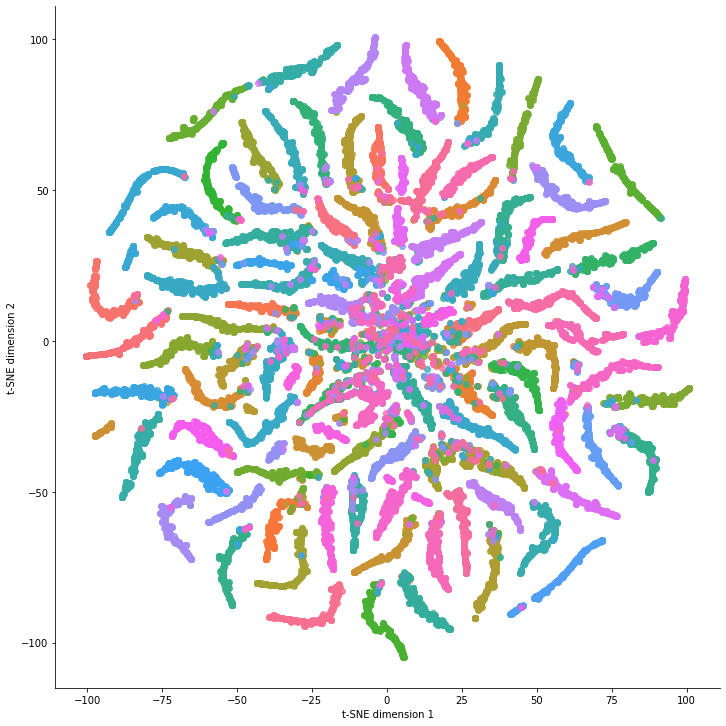

In [34]:
# plot tsne without legend because of large amount of classes
g = sns.lmplot('t-SNE dimension 1', 't-SNE dimension 2', data=prob_df, hue='labels', fit_reg=False, legend=False, height=10, seed=42)

Clusters look fairly separable with some prediction blurring and mixup torwards the center of the plot.

### 2. TSNE on commonly confused food classes

In [36]:
# rebuild TSNE based on frequently confused classes
food_classes_confused = ['steak', 'filet_mignon', 'prime_rib', 'pork_chop']

codes_c = [data_test.classes.index(i) for i in food_classes_confused]

preds_c = [preds_tta[y_tta==i] for i in codes_c]
ys_c = [y_tta[y_tta==i] for i in codes_c]

preds_stack_c = torch.cat(preds_c, dim=0)
ys_stack_c = torch.cat(ys_c, dim=0)

In [37]:
tsne_c = manifold.TSNE(n_components=2, perplexity=15).fit_transform(preds_stack_c)

In [38]:
df_c = pd.DataFrame(np.concatenate((tsne_c, ys_stack_c[:,None]), axis=1), columns=['t-SNE dimension 1','t-SNE dimension 2','labels'])

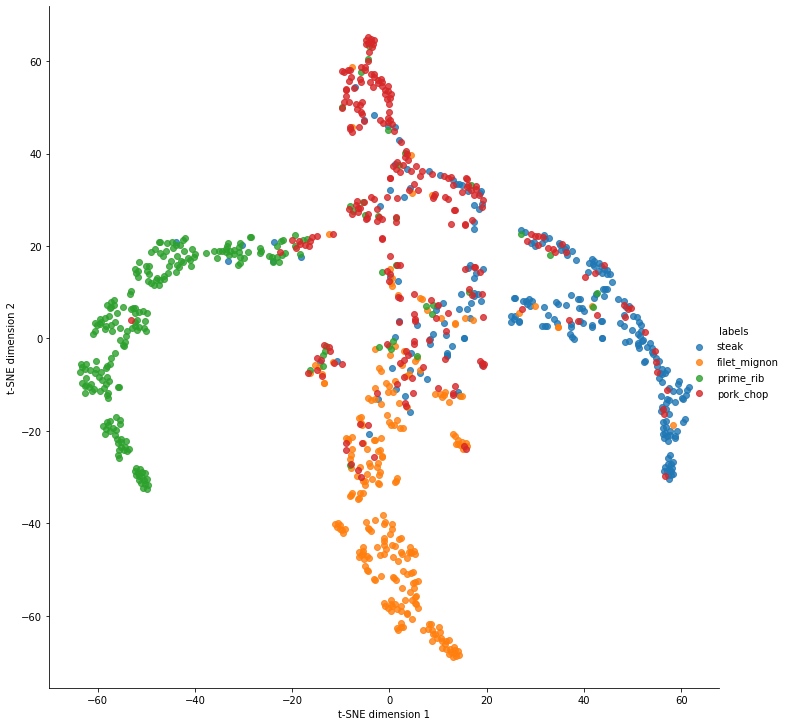

In [39]:
# plot tsne
h = sns.lmplot('t-SNE dimension 1', 't-SNE dimension 2', data=df_c, hue='labels', fit_reg=False, legend=True, height=10)

# rename legenda labels
for t, l in zip(h._legend.texts, food_classes_confused): 
  t.set_text(l)

Here we definitely notice more intra-cluster mixup of the predictions.

### 3. TSNE on dissimilar food classes

In [40]:
# rebuild TSNE based on classes that are generally not confused with each other
food_classes_not_confused = ['cup_cakes', 'creme_brulee','fried_rice','caesar_salad','lasagna']

codes_nc = [data_test.classes.index(i) for i in food_classes_not_confused]

preds_nc = [preds_tta[y_tta==i] for i in codes_nc]
ys_nc = [y_tta[y_tta==i] for i in codes_nc]

preds_stack_nc = torch.cat(preds_nc, dim=0)
ys_stack_nc = torch.cat(ys_nc, dim=0)

In [41]:
tsne_nc = manifold.TSNE(n_components=2, perplexity=10).fit_transform(preds_stack_nc)

In [42]:
df_nc = pd.DataFrame(np.concatenate((tsne_nc, ys_stack_nc[:,None]), axis=1), columns=['t-SNE dimension 1','t-SNE dimension 2','labels'])

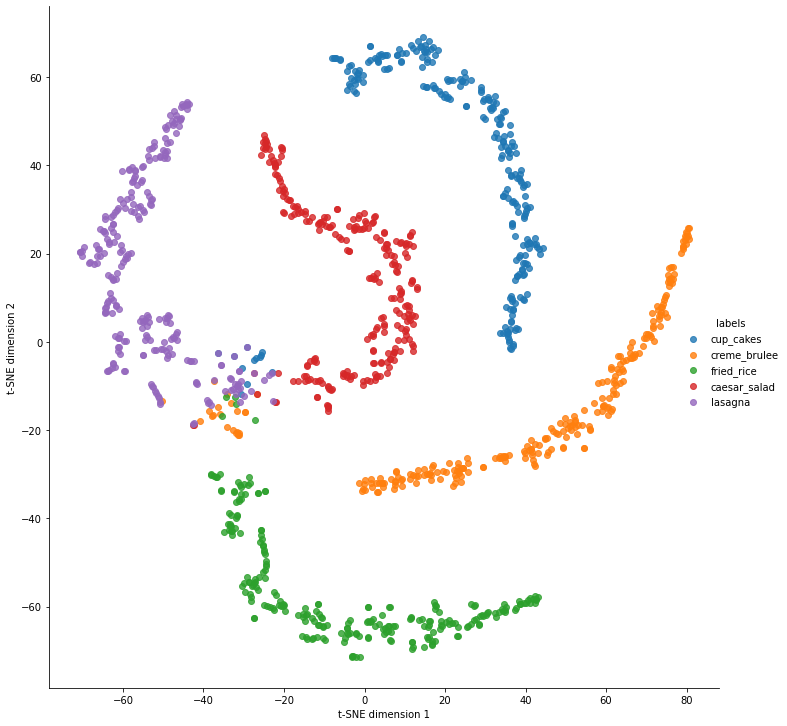

In [43]:
w = sns.lmplot('t-SNE dimension 1', 't-SNE dimension 2', data=df_nc, hue='labels', fit_reg=False, legend=True, height=10)

for t, l in zip(w._legend.texts, food_classes_not_confused): 
  t.set_text(l)

Since the food classes are quite dissimilar, clusters are unsurprisingly quite separable.

----

As a conclusion, by testing the classifier on 512 x 512 resolution images, we have increased our **<mark>top-1 accuracy<mark/>** from 86.4% to **<mark>90.1%<mark/>** and our **<mark>top-5 accuracy<mark/>** from 97.4% to **<mark>98.4%<mark/>**.

----